In [1]:
from itertools import islice
from pyexpat import features

import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.measure import shannon_entropy

In [2]:
train_df = pd.read_csv("./dataset/splits/train.csv", index_col='index')
test_df = pd.read_csv("./dataset/splits/test.csv", index_col='index')
val_df = pd.read_csv("./dataset/splits/validation.csv", index_col='index')
train_df.head()

,clip_name,clip_path,label,encoded_label
index,,,,
0,v_Diving_g03_c01.avi,./dataset/Diving/v_Diving_g03_c01.avi,Diving,0
1,v_Diving_g19_c03.avi,./dataset/Diving/v_Diving_g19_c03.avi,Diving,0
2,v_Diving_g03_c04.avi,./dataset/Diving/v_Diving_g03_c04.avi,Diving,0
3,v_Diving_g05_c04.avi,./dataset/Diving/v_Diving_g05_c04.avi,Diving,0
4,v_Diving_g15_c03.avi,./dataset/Diving/v_Diving_g15_c03.avi,Diving,0


In [3]:
CONFIG = {
    'frame_skip': 5,  # Process every 5th frame to speed up
    'resize_dim': (224, 224),
    'n_jobs': -1,  # Use all CPU cores for feature extraction

    'lbp_radius': 3,
    'lbp_points': 8,

    'gabor': {
        'ksize': 5,
        'sigma': 3,
        'theta': 1*np.pi/4,
        'lamda': 1*np.pi /4,
        'gamma':0.4,
        'phi': 0
    },

    'contour': {
        'count' : 3,
    },

    'lucas_kanade': {
        'max_corners': 10,
        'quality_level': .3,
        'min_distance': 7,
        'block_size': 7
    },
}

In [4]:
class TemporalFeatureExtractor:
    def __init__(self, window_len):
        self.window_len = window_len
        self.feature_buffer = []

    def update(self, frame_features: dict):
        self.feature_buffer.append(frame_features)
        if len(self.feature_buffer) > self.window_len:
            self.feature_buffer.pop(0)
        return self._get_temporal_features()

    def _get_temporal_features(self):
        features = {}
        df = pd.DataFrame(self.feature_buffer)
        for col in df.columns:
            features[f"{col}_mean"] = df[col].mean()
            features[f"{col}_std"] = df[col].std()
            features[f"{col}_min"] = df[col].min()
            features[f"{col}_max"] = df[col].max()
            deltas = df[col].diff()
            avg_delta = deltas.mean()
            features[f"{col}_delta_mean"] = avg_delta
        if len(self.feature_buffer) > 2:
            slope = np.polyfit(range(len(self.feature_buffer)), df['motion_avg_intensity'], 1)[0]
        else:
            slope = 0
        features[f"motion_slope"] = slope

        return features

In [5]:
class VideoExtractorFeature:
    def __init__(self, skip_frame:int =5):
        self.skip_frame = skip_frame
        self.scalar = MinMaxScaler()
        self.gabor_kernel = cv.getGaborKernel(
            (CONFIG['gabor']['ksize'], CONFIG['gabor']['ksize']),
            CONFIG['gabor']['sigma'],
            CONFIG['gabor']['theta'],
            CONFIG['gabor']['lamda'],
            CONFIG['gabor']['gamma'],
            CONFIG['gabor']['phi'],
        )
        self.temporal_feat_extractor = TemporalFeatureExtractor(5)

    def _get_frame_color_features(self, frame):
        hsv_frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        features = {}
        for i, colour in enumerate(['red', 'blue', 'green']):
            channel = rgb_frame[:, :, i]
            hist, _ = np.histogram(channel.ravel(), bins=10,)
            hist = hist.astype('float')
            hist /= (hist.sum() + 1e-7)
            for j in range(len(hist)):
                features[f'color_{colour}_{j}'] = hist[j]

        for i, column_name in enumerate(['h', 's', 'v']):
            channel = hsv_frame[:, :, i]

            mean = np.mean(channel)
            std = np.std(channel)

            if std < 1e-6:
                skewness = 0
            else:
                skewness = skew(channel.flatten())
                if np.isnan(skewness):
                    skewness = 0

            features[f'moments_mean_{column_name}'] = mean
            features[f'moments_std_{column_name}'] = std
            features[f'moments_skew_{column_name}'] = skewness

        avg_rgb  = np.mean(rgb_frame, axis=(0, 1))
        features['avg_color_r'] = avg_rgb[0]
        features['avg_color_g'] = avg_rgb[1]
        features['avg_color_b'] = avg_rgb[2]
        return features

    def _get_frame_glcm_features(self, grey_frame):
        features = {}
        for distance in [1, 3, 5]:
            for angle, orientation in zip([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], ["0", "45", "90", "135"]):
                glcm = graycomatrix(grey_frame, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
                features[f'glcm_contrast_{distance}_{orientation}'] = graycoprops(glcm, 'contrast')[0, 0]
                features[f'glcm_dissimilarity_{distance}_{orientation}'] = graycoprops(glcm, 'dissimilarity')[0, 0]
                features[f'glcm_homogeneity_{distance}_{orientation}'] = graycoprops(glcm, 'homogeneity')[0, 0]
                features[f'glcm_correlation_{distance}_{orientation}'] = graycoprops(glcm, 'correlation')[0, 0]
                features[f'glcm_energy_{distance}_{orientation}'] = graycoprops(glcm, 'energy')[0, 0]
        features['glcm_entropy'] = shannon_entropy(grey_frame)
        return features

    def _lbp_features(self, grey_frame):
        lbp = local_binary_pattern(grey_frame, CONFIG['lbp_points'], CONFIG['lbp_radius'], method='uniform')
        hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, CONFIG['lbp_points'] + 3),
                               range=(0, CONFIG['lbp_points'] + 2))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)

        features = {}
        for i in range(len(hist)):
            features[f'lbp_{i}'] = hist[i]
        return features

    def _get_gabor_features(self, grey_frame):
        gabor_features = cv.filter2D(grey_frame, cv.CV_8UC3, self.gabor_kernel)

        hist, _ = np.histogram(gabor_features.ravel(), bins=10,)
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)

        features = {}
        for i in range(len(hist)):
            features[f'gabor_{i}'] = hist[i]
        return features

    def _get_canny_features(self, grey_frame):
        sigma = 0.3
        median = np.median(grey_frame)
        lower = int(max(0, (1.0 - sigma) * median))
        upper = int(min(255, (1.0 + sigma) * median))
        edges = cv.Canny(grey_frame, lower, upper, edges=grey_frame)

        hist, _ = np.histogram(edges.ravel(), bins=10,)
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)

        features = {}
        for i in range(len(hist)):
            features[f'canny_{i}'] = hist[i]
        return features

    def _get_contour_features(self, grey_frame):
        sigma = 0.2
        median = np.median(grey_frame)
        lower = int(max(0, (1.0 - sigma) * median))
        upper = int(min(255, (1.0 + sigma) * median))
        ret, img_th = cv.threshold(grey_frame, lower, upper, cv.THRESH_BINARY_INV)
        contours, hierarchy = cv.findContours(img_th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        features = {}
        for i in range(CONFIG['contour']['count']):
            features[f'contour_{i}_area'] = -1
            features[f'contour_{i}_perimeter'] = -1

        for i, contour in enumerate(islice(contours, min(CONFIG['contour']['count'], len(contours)))):
            m = cv.moments(contour)
            features[f'contour_{i}_area'] = m['m00']
            features[f'contour_{i}_perimeter'] = m['m01'] / (m['m00'] + 1e-7)
            # 'contour_aspect_ratio': m['m10'] / m['m00'],
            # 'contour_eccentricity': cv.contourArea(contours[0]) / cv.arcLength(contours[0], True),
            # 'contour_extent': cv.contourArea(contours[0]) / (grey_frame.shape[0] * grey_frame.shape[1]),
            # 'contour_solidity': cv.contourArea(contours[0]) / cv.contourArea(cv.convexHull(contours[0])),
        return features

    def _get_hog_features(self, grey_frame):
        features = {}
        feature = hog(grey_frame, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
        for i in range(len(feature)):
            features[f'hog_{i}'] = feature[i]
        return features

    def _get_lucas_kanade_features(self, prev_frame, curr_frame):
        p0 = cv.goodFeaturesToTrack(prev_frame,
                               mask=None, maxCorners=CONFIG['lucas_kanade']['max_corners'], qualityLevel=CONFIG['lucas_kanade']['quality_level'], minDistance=CONFIG['lucas_kanade']['min_distance'], blockSize=CONFIG['lucas_kanade']['block_size'])
        if p0 is None:
            feature = np.zeros(CONFIG['lucas_kanade']['max_corners'] * 2)
        else:
            lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
            p1, st, err = cv.calcOpticalFlowPyrLK(prev_frame, curr_frame, p0, None, **lk_params)
            good_new = p1[st == 1]
            good_old = p0[st == 1]
            displacements = good_new - good_old
            if len(displacements) < CONFIG['lucas_kanade']['max_corners']:
                padding = np.zeros((CONFIG['lucas_kanade']['max_corners'] - len(displacements), 2))
                displacements = np.concatenate((displacements, padding), axis=0)
            else:
                displacements = displacements[:CONFIG['lucas_kanade']['max_corners']]

            feature = displacements.flatten()

        features = {}
        for i in range(len(feature)):
            features[f'lk_{i}'] = feature[i]
        return features

    def _get_motion_features(self, prev_frame, curr_frame):
        # flow = self.hs_flow.calc(prev_frame, curr_frame, None)
        flow = cv.calcOpticalFlowFarneback(
            prev_frame, curr_frame, None,
            pyr_scale=0.5,
            levels=3,
            winsize=15,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0,
        )

        u = flow[..., 0]
        v = flow[..., 1]

        mag, ang = cv.cartToPolar(u, v, angleInDegrees=True)
        mag_hist, _ = np.histogram(mag, bins=10, range=(0, 10))
        ang_hist, _ = np.histogram(ang, bins=8, range=(0, 360), weights=mag)
        avg_intensity = np.mean(mag)
        dominant_direction = np.argmax(ang_hist) * 45  # Back to degrees (8 bins = 45 deg/bin)

        features = {}
        for i in range(len(mag_hist)):
            features[f'motion_magnitude_{i}'] = mag_hist[i]
        for i in range(len(ang_hist)):
            features[f'motion_direction_{i}'] = ang_hist[i]
        features['motion_avg_intensity'] = avg_intensity
        features['motion_dominant_direction'] = dominant_direction
        return features

    def _process_video(self, row: dict):
        video_id = row['index']
        video_path = row['clip_path']
        cap = cv.VideoCapture(video_path)
        features = []
        frame_cnt = 0
        prev_grey_frame = None

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_cnt % self.skip_frame == 0:
                frame = cv.resize(frame, CONFIG['resize_dim'], interpolation=cv.INTER_AREA)
                grey_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
                if prev_grey_frame is None:
                    prev_grey_frame = grey_frame
                feat = {'index': video_id}
                feat.update(self._get_frame_color_features(frame))
                feat.update(self._get_frame_glcm_features(grey_frame))
                feat.update(self._lbp_features(grey_frame))
                feat.update(self._get_gabor_features(grey_frame))
                feat.update(self._get_canny_features(grey_frame))
                feat.update(self._get_contour_features(grey_frame))
                feat.update(self._get_hog_features(grey_frame))
                feat.update(self._get_lucas_kanade_features(prev_grey_frame, grey_frame))
                motion_feat = self._get_motion_features(prev_grey_frame, grey_frame)
                print(f"s: {len(self.temporal_feat_extractor.update(motion_feat))}")
                feat.update(motion_feat)
                features.append(feat)
                prev_grey_frame = grey_frame
            frame_cnt += 1

        cap.release()
        return features

    def _normalize_features(self, feature_df: pd.DataFrame, is_test: bool = False):
        feature_names = [col for col in feature_df.columns if col not in ['index', 'encoded_label']]
        feature_df[feature_names] = feature_df[feature_names].astype(float)
        if is_test:
            feature_df[feature_names] = self.scalar.transform(feature_df[feature_names])
        else:
            feature_df[feature_names] = self.scalar.fit_transform(feature_df[feature_names])
        return feature_df

    def _process_dataset(self, df: pd.DataFrame, is_test=False):
        rows = df.reset_index().to_dict('records')
        nested_results = Parallel(n_jobs=-1)(delayed(self._process_video)(row) for row in rows)

        flatten_results = [item for sub_list in nested_results for item in sub_list]
        feature_df = pd.DataFrame(flatten_results)
        return self._normalize_features(feature_df, is_test)

    def process_train_df(self, df: pd.DataFrame):
        process_df = self._process_dataset(df)
        merged_df = pd.merge(train_df, process_df, on='index', how='inner')
        output = merged_df['encoded_label']
        merged_df = merged_df.drop(columns=['index', 'clip_path', 'clip_name', 'label', 'encoded_label'])
        return merged_df, output

    def process_test_df(self, df: pd.DataFrame):
        process_df = self._process_dataset(df, True)
        merged_df = pd.merge(train_df, process_df, on='index', how='inner')
        merged_df = merged_df.drop(columns=['clip_path', 'clip_name', 'label'])
        return merged_df


In [6]:
extractor = VideoExtractorFeature()

In [7]:
X, Y = extractor.process_train_df(train_df)

In [8]:
M = extractor.process_test_df(val_df)

In [9]:
X.head()

,color_red_0,color_red_1,color_red_2,color_red_3,color_red_4,color_red_5,color_red_6,color_red_7,color_red_8,color_red_9,...,motion_direction_0,motion_direction_1,motion_direction_2,motion_direction_3,motion_direction_4,motion_direction_5,motion_direction_6,motion_direction_7,motion_avg_intensity,motion_dominant_direction
0,0.004031,0.071438,0.197694,0.345833,0.324300,0.243115,0.109002,0.068167,0.046475,0.418683,...,0.000004,0.000008,0.000001,0.000006,0.000008,0.000002,0.000001,0.000005,0.000029,0.142857
1,0.003549,0.070097,0.195956,0.340256,0.329472,0.242652,0.116573,0.065763,0.043464,0.424572,...,0.019859,0.041062,0.038140,0.013508,0.007470,0.001588,0.000636,0.003928,0.105426,0.285714
2,0.005192,0.091114,0.194388,0.347831,0.279159,0.232717,0.128101,0.059780,0.039209,0.433879,...,0.008720,0.039702,0.023652,0.017200,0.025327,0.011158,0.006968,0.015411,0.120252,0.142857
3,0.004163,0.077229,0.194346,0.345306,0.290082,0.245174,0.129174,0.061672,0.041238,0.439350,...,0.012389,0.013392,0.032040,0.025171,0.005335,0.004400,0.002500,0.001263,0.080770,0.285714
4,0.005039,0.097889,0.179680,0.337391,0.286814,0.239203,0.124823,0.055485,0.040584,0.452304,...,0.008576,0.011658,0.069417,0.026908,0.011401,0.004632,0.006077,0.004908,0.123172,0.285714


In [10]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: encoded_label, dtype: int64

In [11]:
feature_names = [col for col in M.columns if col not in ['index', 'encoded_label']]

In [12]:
import optuna.visualization as vis
import cupy as cp
import optuna
from cuml.svm import SVC
import cudf

def validation_pipeline_score(model, merged_df):
    result = 0
    for video_id, group in merged_df.groupby('index'):
        df = group[feature_names]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0]
        # print(f"final_ans: {final_ans}, expected: {expected}, type of expected: {type(expected)}, type of final_ans: {type(final_ans)}, video_id: {video_id}")
        if final_ans == expected:
            result = result + 1
    return result


def objective_function(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params)
    model.fit(X, Y)import optuna.visualization as vis
import cupy as cp
import optuna
from cuml.svm import SVC
import cudf

def validation_pipeline_score(model, merged_df):
    result = 0
    for video_id, group in merged_df.groupby('index'):
        df = group[feature_names]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0]
        # print(f"final_ans: {final_ans}, expected: {expected}, type of expected: {type(expected)}, type of final_ans: {type(final_ans)}, video_id: {video_id}")
        if final_ans == expected:
            result = result + 1
    return result


def objective_function(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params)
    model.fit(X, Y)
    return validation_pipeline_score(model, M)


study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50, show_progress_bar=True, n_jobs=1)



study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50, show_progress_bar=True, n_jobs=1)


[I 2026-02-06 00:27:48,881] A new study created in memory with name: no-name-032fd00c-ebd5-4b3b-a62d-19332b936915


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-06 00:27:50,420] Trial 0 finished with value: 10.0 and parameters: {'C': 0.014783227341485463, 'gamma': 2.440237201297669, 'kernel': 'poly'}. Best is trial 0 with value: 10.0.
[I 2026-02-06 00:27:51,668] Trial 1 finished with value: 10.0 and parameters: {'C': 295.1351345425447, 'gamma': 0.0005157751460611818, 'kernel': 'poly'}. Best is trial 0 with value: 10.0.
[I 2026-02-06 00:27:52,727] Trial 2 finished with value: 10.0 and parameters: {'C': 0.031009229599931503, 'gamma': 0.018185834606465955, 'kernel': 'poly'}. Best is trial 0 with value: 10.0.
[I 2026-02-06 00:27:56,076] Trial 3 finished with value: 0.0 and parameters: {'C': 1.760198022075379, 'gamma': 0.0001995269428333047, 'kernel': 'poly'}. Best is trial 0 with value: 10.0.
[I 2026-02-06 00:28:00,889] Trial 4 finished with value: 16.0 and parameters: {'C': 19.34984755930042, 'gamma': 0.15370685417454538, 'kernel': 'rbf'}. Best is trial 4 with value: 16.0.
[I 2026-02-06 00:28:01,963] Trial 5 finished with value: 10.0 a

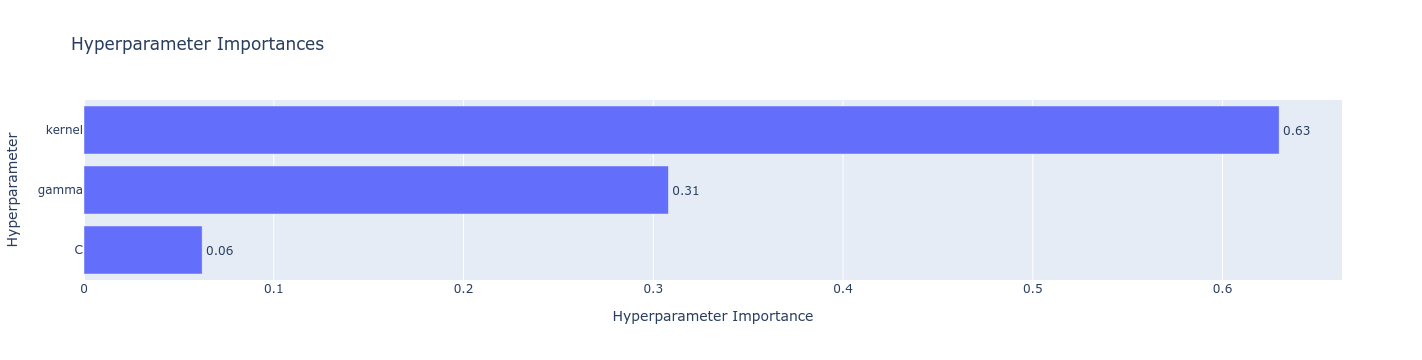

In [13]:
vis.plot_param_importances(study)

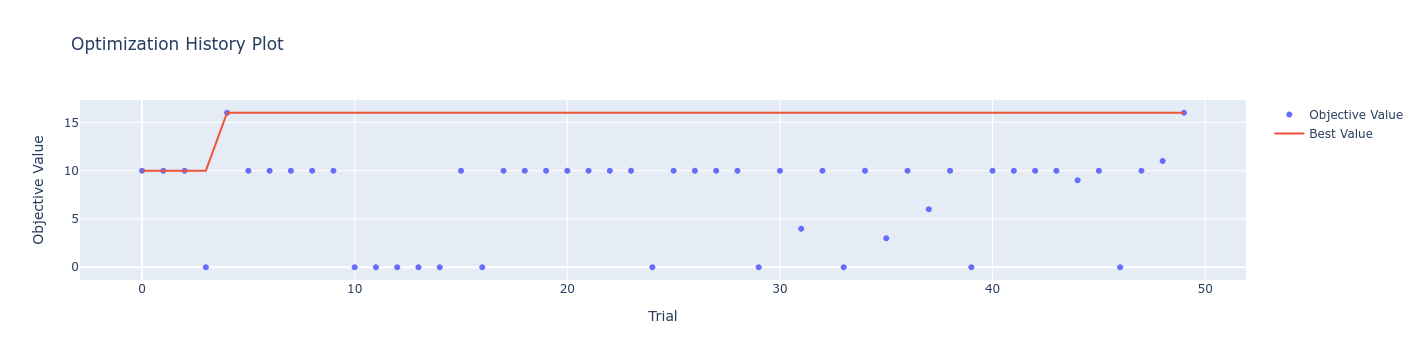

In [14]:
vis.plot_optimization_history(study)

In [16]:
import optuna.visualization as vis
import cupy as cp
import optuna
from cuml.ensemble import RandomForestClassifier
import cudf

def validation_pipeline_score(model, merged_df):
    result = 0
    for video_id, group in merged_df.groupby('index'):
        df = group[feature_names]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0]
        # print(f"final_ans: {final_ans}, expected: {expected}, type of expected: {type(expected)}, type of final_ans: {type(final_ans)}, video_id: {video_id}")
        if final_ans == expected:
            result = result + 1
    return result


def objective_function(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int("max_depth", 2, 256, log=True),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 100),
        'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"])
    }
    model = RandomForestClassifier(**params)
    model.fit(X, Y)
    return validation_pipeline_score(model, M)


study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50, show_progress_bar=True, n_jobs=1)


[I 2026-02-06 01:27:39,569] A new study created in memory with name: no-name-2a0531f5-8f09-4e78-ac75-e7a05c55c6cf


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-06 01:27:40,728] Trial 0 finished with value: 11.0 and parameters: {'n_estimators': 660, 'max_depth': 49, 'min_samples_split': 60, 'criterion': 'gini'}. Best is trial 0 with value: 11.0.
[I 2026-02-06 01:27:41,185] Trial 1 finished with value: 7.0 and parameters: {'n_estimators': 421, 'max_depth': 3, 'min_samples_split': 32, 'criterion': 'gini'}. Best is trial 0 with value: 11.0.
[I 2026-02-06 01:27:41,859] Trial 2 finished with value: 5.0 and parameters: {'n_estimators': 857, 'max_depth': 2, 'min_samples_split': 59, 'criterion': 'entropy'}. Best is trial 0 with value: 11.0.
[I 2026-02-06 01:27:43,502] Trial 3 finished with value: 11.0 and parameters: {'n_estimators': 987, 'max_depth': 49, 'min_samples_split': 28, 'criterion': 'gini'}. Best is trial 0 with value: 11.0.
[I 2026-02-06 01:27:44,164] Trial 4 finished with value: 11.0 and parameters: {'n_estimators': 460, 'max_depth': 9, 'min_samples_split': 62, 'criterion': 'entropy'}. Best is trial 0 with value: 11.0.
[I 2026-0

In [18]:
import optuna.visualization as vis
import cupy as cp
import optuna
from cuml.neighbors import KNeighborsClassifier
import cudf

def validation_pipeline_score(model, merged_df):
    result = 0
    for video_id, group in merged_df.groupby('index'):
        df = group[feature_names]
        output = model.predict(df)
        final_ans = output.mode().iloc[0]
        expected = group['encoded_label'].values[0]
        # print(f"final_ans: {final_ans}, expected: {expected}, type of expected: {type(expected)}, type of final_ans: {type(final_ans)}, video_id: {video_id}")
        if final_ans == expected:
            result = result + 1
    return result


def objective_function(trial):
    params = {
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 100),
        'weights': trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric': trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'p': trial.suggest_int("p", 1, 5)
    }
    model = KNeighborsClassifier(**params)
    model.fit(X, Y)
    return validation_pipeline_score(model, M)


study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50, show_progress_bar=True, n_jobs=1)


[I 2026-02-06 01:31:39,181] A new study created in memory with name: no-name-e7e0109e-c405-45be-a0c2-1263f5db3eab


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-06 01:31:39,630] Trial 0 finished with value: 6.0 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 6.0.
[I 2026-02-06 01:31:40,072] Trial 1 finished with value: 6.0 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2}. Best is trial 0 with value: 6.0.
[I 2026-02-06 01:31:40,511] Trial 2 finished with value: 6.0 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 6.0.
[I 2026-02-06 01:31:40,835] Trial 3 finished with value: 8.0 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'p': 1}. Best is trial 3 with value: 8.0.
[I 2026-02-06 01:31:41,277] Trial 4 finished with value: 4.0 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'minkowski', 'p': 4}. Best is trial 3 with value: 8.0.
[I 2026-02-06 01:31:41,723] Trial 5 finished with value: 5.0 and parameters: {